## **Needed libraries**

In [14]:
import numpy as np
import pandas as pd
import os
import face_recognition as fc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2 as cv
from sklearn import neighbors
import sklearn.metrics as smt

## **Loading dataset**

### **i deleted huge number of images to make it faster**

In [16]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()

Saving Original Images.zip to Original Images.zip


In [17]:
import zipfile
import os

# Define the zip file name and the extraction path
zip_file_name = 'Original Images.zip'
extraction_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Verify the files in the extracted folder
!ls /content/Original Images

ls: cannot access '/content/Original': No such file or directory
ls: cannot access 'Images': No such file or directory


In [18]:
df = pd.read_csv('Dataset.csv')
df

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan
...,...,...
2557,Jessica Alba_90.jpg,Jessica Alba
2558,Elizabeth Olsen_27.jpg,Elizabeth Olsen
2559,Elizabeth Olsen_59.jpg,Elizabeth Olsen
2560,Henry Cavill_7.jpg,Henry Cavill


In [19]:
df.label.value_counts().to_frame()

,count
label,
Brad Pitt,120
Vijay Deverakonda,115
Robert Downey Jr,113
Hugh Jackman,112
Jessica Alba,108
Henry Cavill,106
Natalie Portman,105
Priyanka Chopra,102
Hrithik Roshan,101


## **Face Encoding**

In [26]:
def encode_images(df):
    dir = r'Original Images'
    face_encodings_list = []
    labels_list = []

    for path, label in df.values:
        img_path = os.path.join(dir, label, path)

        try:
            # Try to load the image
            image = fc.load_image_file(img_path)
            face_encodings = fc.face_encodings(image)

            if face_encodings:
                face_encoding = face_encodings[0]
                face_encodings_list.append(face_encoding)
                labels_list.append(label)

        except FileNotFoundError:
              continue

        except Exception as e:
            # Handle any other exceptions
            print(f"An error occurred with file {img_path}: {e}")
            continue

    return face_encodings_list, labels_list


In [27]:
x, y = encode_images(df)

## **Data Splitting**

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y, random_state=42)

## **Classification model**

In [29]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance')

In [30]:
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance')

## **Model Evaluation**

In [31]:
knn_clf.score(x_train, y_train)

1.0

### **Scores**

In [32]:
y_pred = knn_clf.predict(x_test)
precision = smt.precision_score(y_test, y_pred, average='weighted')
recall = smt.recall_score(y_test, y_pred, average='weighted')
f1 = smt.f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


### **Confusion Matrix**

<Axes: >

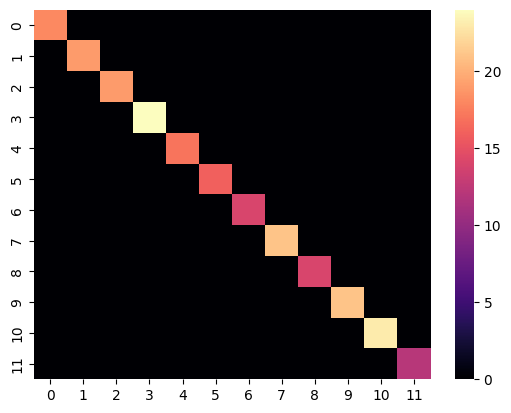

In [33]:
conf_matrix = smt.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix,cmap='magma')

## **Predicting Images**

In [34]:
def show_image(image, x=10, y=8, bgr=False):
    plt.figure(figsize=(x, y))

    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    elif len(image.shape) == 3:
        if bgr:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.imshow(image)

    plt.xticks([])
    plt.yticks([])
    plt.show()


In [35]:
def predict_and_visualize(image_path):
    # Read the image
    image = cv.imread(image_path)
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_height, image_width = image.shape[:2]

    # Predict
    face_locations = fc.face_locations(rgb_image)
    face_encodings = fc.face_encodings(rgb_image, face_locations)

    # Visualize
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):

        matches = knn_clf.kneighbors([face_encoding], n_neighbors=1)
        name = knn_clf.predict([face_encoding])[0] if matches[0][0][0] < 0.5 else "Unknown"

        cv.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        font_scale = image_width / 700.0
        text_position = (left, bottom + int(image_height * 0.06))
        cv.putText(image, name, text_position, cv.FONT_HERSHEY_DUPLEX, font_scale, (0, 255, 0), 2)

    show_image(image, bgr=True)


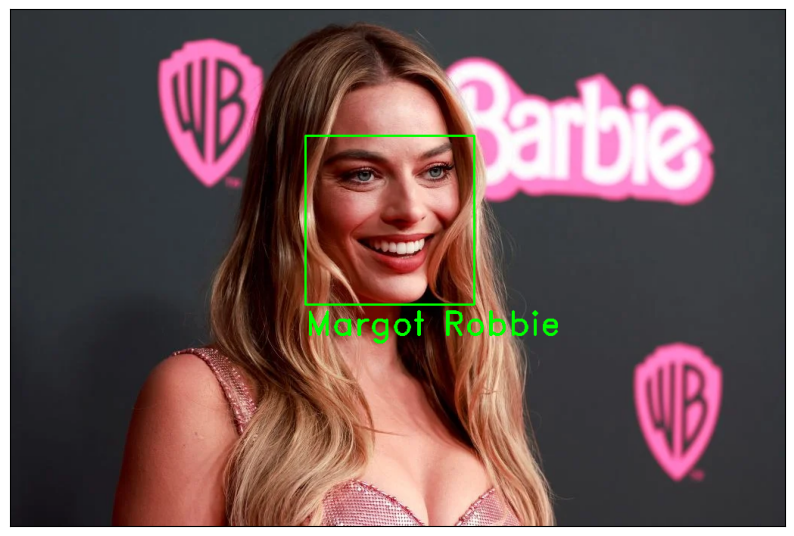

In [36]:
img = '/content/Celebrity Images/Margot Robbie.webp'
predict_and_visualize(img)

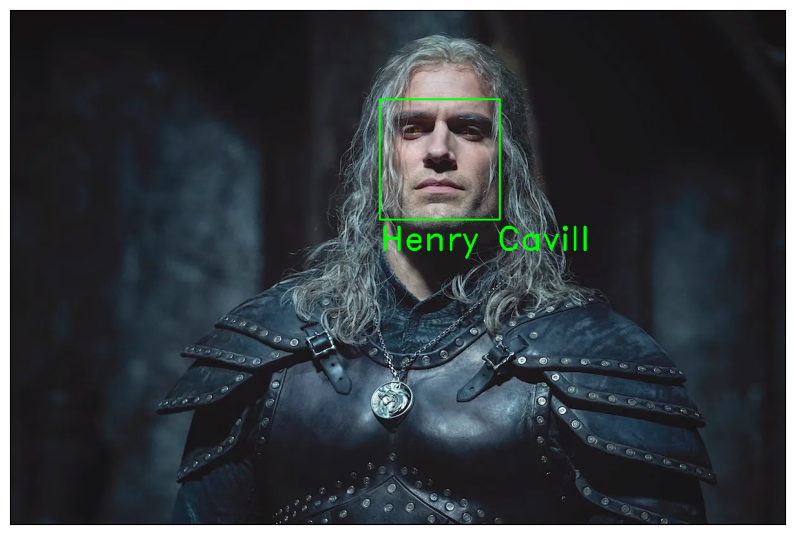

In [37]:
img = '/content/Celebrity Images/henry cavill.webp'
predict_and_visualize(img)

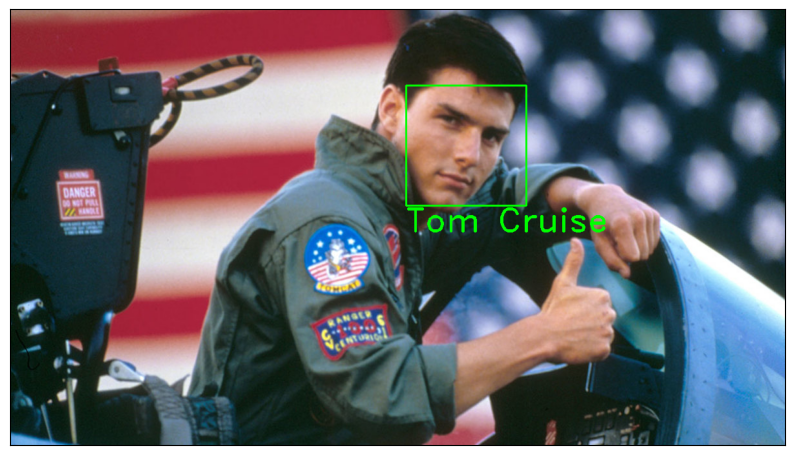

In [38]:
img = '/content/Celebrity Images/tom cruise.jpg'
predict_and_visualize(img)

### **let's try someone not in the dataset**

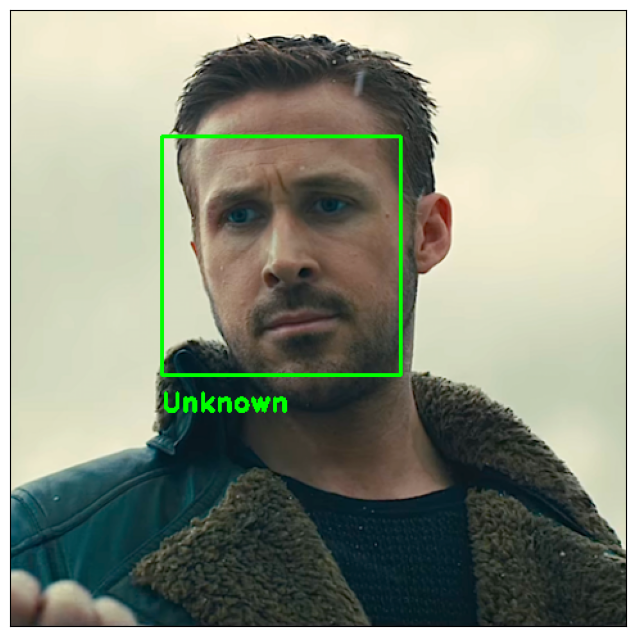

In [39]:
img = '/content/Celebrity Images/Ryan Gosling.png'
predict_and_visualize(img)